<a href="https://colab.research.google.com/github/omicsEye/waveome/blob/main/kernel_learning/gpflow_basic_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
#from helper_functions import pred_kernel_parts, gp_predict_fun, hmc_sampling

In [12]:
#@title Helper functions

# Libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import seaborn as sns
import gpflow
from gpflow.utilities import set_trainable, positive
from gpflow.ci_utils import ci_niter
import re
import contextlib
import joblib
from tqdm import tqdm    
from joblib import Parallel, delayed

f64 = gpflow.utilities.to_default_float

# Classes
class Categorical(gpflow.kernels.Kernel):
    def __init__(self, active_dims, variance=1.0):
        super().__init__(active_dims=active_dims)
        self.variance = gpflow.Parameter(variance, transform=positive())
        #self.rho = gpflow.Parameter(1.0, transform=positive())'
        self.active_index = active_dims[0]
    
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        #X = X[:, self.active_dims[0]]
        #X2 = X2[:, self.active_dims[0]]
        # matches = tf.cast(tf.equal(tf.cast(X, tf.int64), tf.transpose(tf.cast(X2, tf.int64))), tf.float64)
        # diagonals = tf.linalg.diag(self.variance/self.rho, matches.shape[0])
        # return matches
        return self.variance * tf.cast(tf.equal(tf.cast(tf.reshape(X2, (1, -1)), tf.int64), tf.cast(X, tf.int64)), tf.float64)
    
    def K_diag(self, X):
        if len(X.shape) > 1 and X.shape[1] > 1:
            X = X[:, self.active_index]
        return self.variance * tf.cast(tf.reshape(tf.ones_like(X), (-1,)), tf.float64)

class Empty(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(name='empty')
        
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return tf.zeros(tf.linalg.matmul(X, X2).shape)
    
    def K_diag(self, X):
        return tf.reshape(tf.zeros(X.shape[0]), (-1, ))
    
# class Categorical(gpflow.kernels.Kernel):
#     def __init__(self, active_dims):
#         super().__init__(active_dims=active_dims)
#         self.variance = gpflow.Parameter(
#             1.0, 
#             transform=gpflow.utilities.positive()
#         )
#         self.rho = gpflow.Parameter(
#             0.5, 
#             transform=gpflow.utilities.positive()
#         )
    
#     #@tf.autograph.experimental.do_not_convert
#     def K(self, X, X2=None):
#         if X2 is None:
#             X2 = X
#         return (self.variance * self.rho * 
#                 tf.cast(tf.equal(X, tf.reshape(X2,[1,-1])),
#                         tf.float64))
    
#     def K_diag(self, X):
# #         return self.variance #* tf.reshape(X, (-1,))
#         return self.variance * tf.reshape(tf.ones_like(X), (-1,)) + 1e-6

# Helper functions
def gp_predict_fun(gp, #X, Y, x_min, x_max, 
                   x_idx, unit_idx, col_names,
                   unit_label=None, num_funs=10, 
                   ax=None, plot_points=True):  
    """
    Plot marginal closed-form posterior distribution.
    """
    
    # Pull training data from model
    X_train, Y_train = gp.data
    X_train = X_train.numpy()
    Y_train = Y_train.numpy()
    
    # Create test points
# #     x_new = np.zeros_like(X)
# #     x_new[:,x_idx] = np.linspace(x_min, x_max, X.shape[0])
# #     x_new[:, unit_idx] = unit_label
#     x_new = np.zeros((1000, X_train.shape[1]))
#     x_new[:, x_idx] = np.linspace(X_train[:, x_idx].min(),
#                                   X_train[:, x_idx].max(),
#                                   1000)
#     x_new[:, unit_idx] = unit_label
    
    if unit_idx != None:
        x_new = np.tile(
            A=np.median(
                X_train[X_train[:, unit_idx] == unit_label, ],
                axis=0
            ),
            reps=(1000, 1)
        )
    else:
        x_new = np.tile(
            A=np.median(
                X_train,
                axis=0
            ),
            reps=(1000, 1)
        )
    # Add full range of x axis
    x_new[:, x_idx] = np.linspace(
        X_train[:, x_idx].min(),
        X_train[:, x_idx].max(),
        1000
    )

    # Predict mean and variance on new data
#     mean, var = gp.predict_f(x_new)
    mean, var = gp.predict_y(x_new)
    # print('observed:', mean.numpy().flatten()[:5], var.numpy().flatten()[:5])
    mean_f, var_f = gp.predict_f(x_new)
    # print('latent function:', mean_f.numpy().flatten()[:5], var_f.numpy().flatten()[:5])
    
#     return(mean.numpy()[:5], mean_f.numpy()[:5])
    
    # Pull some posterior functions
    tf.random.set_seed(1) 
    samples = gp.predict_f_samples(x_new, num_funs)
    samples = samples[:, :, 0].numpy().T 

    # Transform function samples if not Gaussian
    if gp.likelihood.name == 'gamma':
        samples = gp.likelihood.shape*gp.likelihood.invlink(samples)#.numpy() 
        upper_ci = gp.likelihood.shape*gp.likelihood.invlink(mean_f + 1.96*np.sqrt(var_f)).numpy().flatten()
        lower_ci = gp.likelihood.shape*gp.likelihood.invlink(mean_f - 1.96*np.sqrt(var_f)).numpy().flatten()
    elif gp.likelihood.name == 'bernoulli':
        samples = gp.likelihood.invlink(samples)
        upper_ci = gp.likelihood.invlink(mean_f + 1.96*np.sqrt(var_f)).numpy().flatten()
        # print(upper_ci[:5])
        lower_ci = gp.likelihood.invlink(mean_f - 1.96*np.sqrt(var_f)).numpy().flatten()
        # print('lower:', lower_ci[:5])
    else:
        lower_ci = mean[:, 0] - 1.96 * np.sqrt(var[:, 0])
        upper_ci = mean[:, 0] + 1.96 * np.sqrt(var[:, 0])
    # Generate plot
#     p = plt.figure(figsize=(10, 5))
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,5))
#     p = sns.scatterplot(x=X[:,x_idx],
#                     y=Y.flatten(),
#                     hue=X[:,unit_idx].astype(int).astype(str),
#                         legend=False)
    # Do we want to plot individual points?
    if plot_points:
        # Do we want these points to be weighted by a single unit?
        if unit_idx != None:
            person_rows = X_train[:,unit_idx] == unit_label
            p = sns.scatterplot(x=X_train[person_rows,x_idx],
                            y=Y_train.flatten()[person_rows],
        #                     hue=X[:,unit_idx].astype(int).astype(str),
        #                         legend=False
                               s=100,
                               color='black',
                               ax=ax)
            p = sns.scatterplot(x=X_train[~np.array(person_rows),x_idx],
                            y=Y_train.flatten()[~np.array(person_rows)],
        #                     hue=X[:,unit_idx].astype(int).astype(str),
        #                         legend=False
                               s=20,
                               color='grey',
                               ax=ax)
        else:
            p = sns.scatterplot(x=X_train[: ,x_idx],
                                y=Y_train.flatten(),
                                s=20,
                                color='grey',
                                ax=ax)
    
    p = sns.lineplot(x=x_new[:,x_idx],
#                  y=mean.numpy().flatten(),
                 y=mean.numpy().flatten(),
                 linewidth=2.5,
                    color='darkgreen',
                    ax=ax)

    ax.fill_between(
        x_new[:, x_idx],
        upper_ci, #mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        lower_ci, #mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color='lightgreen',
        alpha=0.5,
    )
    ax.plot(x_new[:,x_idx], 
           samples,#[:, :, 0].numpy().T,# "C0", 
           color='dimgray',
           linewidth=0.5,
           alpha=0.5)
#     plt.close()

    ax.set(
        xlabel=f"{replace_kernel_variables('['+str(x_idx)+']', col_names).strip('[]')}",
        #title=f"{replace_kernel_variables(str(x_idx), col_names)}"
    )
    return(ax)

def calc_bic(loglik, n, k):
    return k*np.log(n)-2*loglik

# Kernel search helper functions
# def coregion_freeze(k):
#     """ Freeze parameters associated with coregion kernel, for individual level effets. """
    
#     if k.name == 'coregion':
#         #print('Found coregion kernel, freezing parameters.')
#         k.W.assign(np.zeros_like(k.W))
#         k.kappa.assign(np.ones_like(k.kappa))
#         set_trainable(k.W, False)
#         set_trainable(k.kappa, False)
# #         set_trainable(k, False)

# def coregion_search(kern_list):
#     """ Search through GP kernel list to find coregion kernels. """
    
#     for k in kern_list:
#         if hasattr(k, 'kernels'):
#             coregion_search(k.kernels)
#         else:
#             coregion_freeze(k)

def print_kernel_names(kernel):
    names = []
    if hasattr(kernel,'kernels')==False:
        return kernel.name
    for i in kernel.kernels:
        if i.name == 'sum':
            sub_names = print_kernel_names(i)
#             names.append('+'.join([x.name for x in i.kernels]))
            names.append('+'.join(sub_names))

        elif i.name == 'product':
            # sub_names = print_kernel_names(i)
            names.append('*'.join([x.name for x in i.kernels]))
            # names.append('*'.join(sub_names))

        else:
            names.append(i.name)

    return(names)

def print_kernel_names2(kernel):
    names = []
    
    if hasattr(kernel, 'kernels') == False:
        return kernel.name
    elif kernel.name == 'sum':
        return [print_kernel_names2(x) for x in kernel.kernels]
        # names.append('+'.join([print_kernel_names2(x) for x in kernel.kernels]))
    elif kernel.name == 'product':
        return '*'.join([print_kernel_names2(x) for x in kernel.kernels])
    return names
            

def kernel_test(X, Y, k, num_restarts=3, random_init=True, verbose=False, likelihood='gaussian'):
    """
    This function evaluates a particular kernel selection on a set of data. 
    
    Inputs:
        X (array): design matrix
        Y (array): output matrix
        k (gpflow kernel): specified kernel
        
    Outputs:
        m (gpflow model): fitted GPflow model
    
    """
            
    # Randomize initial values for a number of restarts
    # np.random.seed(9012)
    best_loglik = -np.Inf
    best_model = None
        
    for i in range(num_restarts):
        
        # Specify model
        if likelihood == 'gaussian':
            m = gpflow.models.GPR(
#             m = gpflow.models.VGP(
                data=(X, Y),
                kernel=k)#+gpflow.kernels.Constant())#,
                #mean_function=gpflow.mean_functions.Constant())#,
#                 likelihood=gpflow.likelihoods.Gaussian())
        elif likelihood == 'exponential':
            m = gpflow.models.VGP(
                data=(X, Y),
                kernel=k,
                # mean_function=gpflow.mean_functions.Constant(),
                likelihood=gpflow.likelihoods.Exponential())
        elif likelihood == 'poisson':
            m = gpflow.models.VGP(
                data=(X, Y),
                kernel=k,
                # mean_function=gpflow.mean_functions.Constant(),
                likelihood=gpflow.likelihoods.Poisson())
        elif likelihood == 'gamma':
            m = gpflow.models.VGP(
                data=(X, Y),
                kernel=k,
                # mean_function=gpflow.mean_functions.Constant(),
                likelihood=gpflow.likelihoods.Gamma())
        elif likelihood == 'bernoulli':
            m = gpflow.models.VGP(
                data=(X, Y),
                kernel=k,#+gpflow.kernels.Constant(),
                # mean_function=gpflow.mean_functions.Constant(),
                likelihood=gpflow.likelihoods.Bernoulli())
        else:
            print('Unknown likelihood requested.')
        
        # Randomize initial values if not trained already
        if random_init:
            for p in m.kernel.trainable_parameters:
                if p.numpy() == 1:
                    p.assign(
                        np.random.uniform(
                            size=p.numpy().size
                        ).reshape(p.numpy().shape)
                    )
        
        # Optimization step for hyperparameters
        try:
            opt_results = gpflow.optimizers.Scipy().minimize(
                m.training_loss,
                m.trainable_variables,
                options={'maxiter': 1000}
            )
        except Exception as e:
            if verbose:
                print(f'Optimization not successful, skipping. Error: {e}')
            if best_model == None and i == num_restarts - 1:
                return best_model, -1*best_loglik
            continue
        
#         print(opt_results)
        
        # Check if better values found and save if so
#         if m.log_marginal_likelihood() > best_loglik:
        if m.log_posterior_density() > best_loglik:
            best_loglik = m.log_posterior_density() #m.log_marginal_likelihood()
            best_model = gpflow.utilities.deepcopy(m)
            if verbose:
                print(f'New best log likelihood: {best_loglik.numpy()}')
            
#     # Set hyperparameters to best found values
#     for l in range(len(m.trainable_parameters)):
#         print(best_params[l])
#         m.trainable_parameters[l].assign(best_params[l])    

    # Calculate information criteria
    bic = round(calc_bic(
#         loglik=best_model.log_marginal_likelihood().numpy(),
        loglik=best_model.log_posterior_density().numpy(),
                   n=X.shape[0],
                   k=len(m.trainable_parameters)),
               2)
    
    # Print out info if requested
    if verbose:
        print(f'Model: {print_kernel_names(k)}, BIC: {bic}')
    
    # Return fitted GP model and bic
    # Predictions
#     print(best_model.predict_f(X))
    return best_model, bic

def set_feature_kernels(f, kern_list, cat_vars):
    if f in cat_vars:
        k_list = [Categorical(active_dims=[f])]
    else:
        k_list = kern_list.copy()
        for k_ in k_list:
            k_.active_dims = np.array([f])
    return k_list

def loc_kernel_search(X, Y, kern_list, 
                      base_kern=None, base_name=None, 
                      cat_vars=[],
                      depth=0,
                      operation='sum',
                      prod_index=None,
                      prev_models=None,
                      lik='gaussian',
                      verbose=False):
    """
    This function performs the local kernel search.
    """
    
    bic_dict = {} 
    
    if verbose:
        print(f'Base kernel: {base_name}')
    
    # Search over features in X
    for f in np.arange(X.shape[1]):
        if verbose:
            print(f'Working on feature {f} now')
            
        temp_kern_list = [gpflow.utilities.deepcopy(x) for x in kern_list]
        # Set kernel list based on feature currently searching
        k_list = set_feature_kernels(f=f,
                                     kern_list=temp_kern_list,
                                     cat_vars=cat_vars)
        # Add no /static/ kernel to test if first level and first feature
        if f==0 and depth==1:# and lik=='gaussian':
            #print(f'Current list of kernels: {k_list}')
            empty_kernel = gpflow.kernels.Constant(variance=1e-6)
            set_trainable(empty_kernel.variance, False)
            k_list += [empty_kernel]
            # k_list += [Empty()]
            
        # Search over kernels
        for k in k_list:
            
            # Get kernel name and dimension
            k_info = k.name + str(k.active_dims) if k.name != 'constant' else k.name
            if verbose:
                print('Current kernel being tested: {}'.format(k_info))
            
            # Update kernel information with base if possible
            if base_kern != None:
                # Make copy of base_kern
                base_kern_ = gpflow.utilities.deepcopy(base_kern)
                
                # Set parameters back to zero 
                for p in base_kern_.trainable_parameters:
                    p.assign(1.)
                
#                 # Check if the new kernel is a copy of the previous categorical kernel
#                 # this would be redundant
#                 if k.name == 'categorical' and k_info in base_name:
#                     continue
                if operation == 'sum':
                    # Skip operation if categorical kernel exists
                    if 'categorical['+str(f)+']' in base_name:
                        continue
                    #    # print('Sum kernel being performed.')
                    try:
                        # Get order correct
                        if base_name < k_info:
                            k = gpflow.kernels.Sum(kernels = [base_kern_, k])
                            k_info = base_name + '+' + k_info
                        else:
                            k = gpflow.kernels.Sum(kernels = [k, base_kern_])
                            k_info = k_info + '+' + base_name 
                            
                        # Make sure this is something that hasn't been tested yet
                        if check_if_model_exists(k_info, prev_models):
                            continue
                        
                        m, bic = kernel_test(X, Y, k, likelihood=lik, verbose=verbose)
#                             print(k_info)
                        # bic_dict[k_info] = [k, m, bic, depth, base_name]
                        bic_dict[k_info] = {
                            'kernel': k,
                            'model': m,
                            'bic': bic,
                            'depth': depth,
                            'parent': base_name,
                            'try_next': True
                        }
        
                    except:
                        None
                    
                elif operation == 'product':       
                    # Skip operation if categorical kernel exists
                    if 'categorical['+str(f)+']' in base_name:
                        continue
                    #     #print('Product kernel being performed.')
                    
                    # Skip if already a product (i.e. only allow two-way interactions
                    if '*' in base_name:
                        continue
                    
                    try:
                        # Set new variance to 1, don't train
                        try:
                            set_trainable(k.variance, False)
                        except:
                            set_trainable(k.base_kernel.variance, False)
                        
                        # Get order correct
                        if base_name < k_info:
                            k = gpflow.kernels.Product(kernels = [base_kern_, k])
                            k_info = base_name + '*' + k_info
                        else:
                            k = gpflow.kernels.Product(kernels = [k, base_kern_])
                            k_info = k_info + '*' + base_name 
                            
                        # Make sure this is something that hasn't been tested yet
                        if check_if_model_exists(k_info, prev_models):
                            continue
                            
                        m, bic = kernel_test(X, Y, k, likelihood=lik, verbose=verbose)
#                             print(k_info)
                        # bic_dict[k_info] = [k, m, bic, depth, base_name]
                        bic_dict[k_info] = {
                            'kernel': k,
                            'model': m,
                            'bic': bic,
                            'depth': depth,
                            'parent': base_name,
                            'try_next': True
                        }                    
                    except:
                        None
                    
                elif operation == 'split_product':
                    #print('Split product being tested.')
                    # Set new variance to 1, don't train
                    try:
                        set_trainable(k.variance, False)
                    except:
                        set_trainable(k.base_kernel.variance, False)
                    new_dict = prod_kernel_creation(X=X,
                                                    Y=Y,
                                                    base_kernel=base_kern_,
                                                    base_name=base_name,
                                                    new_kernel=k,
                                                    depth=depth,
                                                    lik=lik)
                    bic_dict.update(new_dict)
            else:
                m, bic = kernel_test(X, Y, k, likelihood=lik, verbose=verbose)
                # bic_dict[k_info] = [k, m, bic, depth, 'None']
                bic_dict[k_info] = {
                    'kernel': k,
                    'model': m,
                    'bic': bic,
                    'depth': depth,
                    'parent': 'None',
                    'try_next': True
                }
            
    return bic_dict

def prod_kernel_creation(X, Y, base_kernel, base_name, new_kernel, depth, lik, verbose=False):
    """
    Produce kernel for product operation
    """
    
    bic_dict = {}
    
    for feat in range(len(base_kernel.kernels)):
        temp_kernel = gpflow.utilities.deepcopy(base_kernel)
        temp_kernel.kernels[feat] = temp_kernel.kernels[feat] * new_kernel
        temp_name = base_name.split('+')
        k_info = new_kernel.name + str(new_kernel.active_dims)
        # Skip operation if categorical kernel exists
        #print('k_info:',k_info,'temp_name:',temp_name[feat])
        if 'categorical'+str(new_kernel.active_dims) not in temp_name[feat]:
            # print('Testing feature')
            
            # Only allow two-way interactions currently
            if '*' in temp_name[feat]:
                continue
            
            try:
                # Get order correct
                if temp_name[feat] < k_info:
                    temp_name[feat] = temp_name[feat] + '*' + k_info
                else:
                    temp_name[feat] = k_info + '*' + temp_name[feat]
                k_info = '+'.join(temp_name)

                m, bic = kernel_test(X, Y, temp_kernel, likelihood=lik, verbose=verbose)
                #print(k_info)
                # bic_dict[k_info] = [temp_kernel, m, bic, depth, base_name]
                bic_dict[k_info] = {
                    'kernel': temp_kernel,
                    'model': m,
                    'bic': bic,
                    'depth': depth,
                    'parent': base_name,
                    'try_next': True
                }
                
            except:
                print('Error!')
                None
        
    return bic_dict

def check_if_better_metric(model_dict, depth): #previous_dict, current_dict):
    """
    Check to see if a better metric was found in current layer, otherwise end search.
    """
    
    prev_vals = [x['bic'] for x in model_dict.values() if x['depth'] == (depth-1)]
    new_vals = [x['bic'] for x in model_dict.values() if x['depth'] == (depth)]
    if len(prev_vals) > 0 and len(new_vals) >0:
        best_prev = min(prev_vals)
        best_new = min(new_vals)
    else:
        return False
    
    return True if best_new < best_prev else False

def keep_top_k(res_dict, depth, metric_diff = 6):
    
    best_bic = np.Inf
    out_dict = res_dict.copy()
    
    # Find results from the current depth
    best_bic = min([v['bic'] for k,v in res_dict.items() if v['depth'] == depth])
#     for k,v in res_dict.items():
#         if v[3] == depth and v[2] < best_bic:
    
    # Only keep results in diff window
    for k, v in res_dict.items():
        if v['depth'] == depth and (v['bic']-best_bic) > metric_diff:
            v['try_next'] = False
            #out_dict.pop(k)
        
    return out_dict

def prune_best_model(res_dict, depth, lik, verbose=False):
    
    out_dict = res_dict.copy()
    
    # Get best model from current depth
    best_bic, best_model_name, best_model = min(
        [(i['bic'], k, i['model']) for k, i in res_dict.items()]
        )
#     print(f'Best model: {best_model_name}')
    
    # Split kernel name to sum pieces 
    kernel_names = best_model_name.split('+')
    
    # Loop through each kernel piece and prune out refit and evaluate
    if len(kernel_names) <= 1:
#         print('No compound terms to prune!')
        return res_dict
    
    for i in range(len(kernel_names)):
        # k = gpflow.kernels.Sum(
        #     kernels = [k_ for i_, k_ in enumerate(best_model.kernel.kernels) 
        #                if i_ != i])
        k_info = '+'.join([x_ for i_,x_ in enumerate(kernel_names) if i_ != i])
        kerns = [k_ for i_, k_ in enumerate(best_model.kernel.kernels) 
                           if i_ != i]
        if len(kerns) > 1:
            k = gpflow.kernels.Sum(kernels = kerns)
        else:
            k = kerns[0]
            
        m, bic = kernel_test(best_model.data[0], best_model.data[1], k, likelihood=lik, verbose=verbose)
        # If better model found then save it
        if bic < best_bic:
#             print(f'New better model found: {k_info}')
            #out_dict[k_info] = [k, m, bic, depth, best_model_name]
            out_dict[k_info] = {
                'kernel': m.kernel,
                'model': m,
                'bic': bic,
                'depth': depth,
                'parent': best_model_name,
                'try_next': True
            }
    return out_dict

# def prune_best_model2(result_dict, lik, verbose=False):
    
#     # Get the best model
#     best_bic, best_model_name, best_model = min(
#         [(i['bic'], k, i['model']) for k, i in res_dict.items()]
#     )
    
#     # See if the kernel is a compound kernel, if not no pruning will be done
#     if best_model.kernel.name not in ['sum', 'product']:
#         return None
    
#     # Otherwise go through each component
#     for k in best_model.kernel.kernels:
        
    
    

def full_kernel_search(X, Y, kern_list, cat_vars=[], max_depth=5, 
                       keep_all=False, metric_diff=6, early_stopping=True, prune=False,
                       lik='gaussian', verbose=False, keep_only_best=True,
                       softmax_select=False, random_seed=None):
    """ 
    This function runs the entire kernel search, calling helpers along the way.
    """
    
    # Set seed if requested
    if random_seed != None:
        np.random.seed(random_seed)
    
    # Create initial dictionaries to insert
    search_dict = {}
    edge_list = []
    
    # Make sure the inputs are in the correct format
    X = X.to_numpy().reshape(-1, X.shape[1])
    Y = Y.to_numpy().reshape(-1, 1)
    
    # Flag for missing values 
    x_idx = ~np.isnan(X).any(axis=1)
    y_idx = ~np.isnan(Y).flatten()
    
    # Get complete cases        
    comp_X = X[x_idx & y_idx]
    comp_y = Y[x_idx & y_idx]
    
    X = comp_X
    Y = comp_y
    
    # Go through each level of depth allowed
    for d in range(1, max_depth+1):
        if verbose:
            print(f'Working on depth {d} now')
        # If first level then there is no current dictionary to update
        if d == 1:
            search_dict = loc_kernel_search(
                X=X, 
                Y=Y, 
                kern_list=kern_list, 
                cat_vars=cat_vars,
                depth=d,
                lik=lik,
                verbose=verbose
            )
        else:
            # Create temporary dictionary to hold new results
            temp_dict = search_dict.copy()
            for k in search_dict.keys():
                # Make sure to only search through the previous depth
                # and that it is a kernel we want to continue searching down
                # and it isn't constant
                if (search_dict[k]['depth'] != d-1 or 
                    search_dict[k]['try_next'] == False or
                    k == 'constant'):
                        continue
                
                # # Make sure to not continue the search for constant kernel
                # if k == 'constant':
                #     continue
                
                cur_kern = search_dict[k]['kernel']
                
                new_res = loc_kernel_search(
                    X=X, 
                    Y=Y, 
                    kern_list=kern_list,
                    base_kern=cur_kern,
                    base_name=k,
                    cat_vars=cat_vars,
                    depth=d,
                    lik=lik,
                    operation='sum',
                    prev_models=temp_dict.keys(),
                    verbose=verbose
                )
                temp_dict.update(new_res)
                
                # Update graph dictionary
                for k_ in new_res.keys():
                    edge_list += [(k, k_)]
                
                # For product break up base kernel and push in each possibility
                # else just simple product with single term
                op = 'split_product' if cur_kern.name == 'sum' else 'product'
                new_res = loc_kernel_search(
                    X=X, 
                    Y=Y, 
                    kern_list=kern_list,
                    base_kern=cur_kern,
                    base_name=k,
                    cat_vars=cat_vars,
                    depth=d,
                    lik=lik,
                    operation=op,
                    prev_models=temp_dict.keys(),
                    verbose=verbose
                )
                temp_dict.update(new_res)
                
                # Update graph dictionary
                for k_ in new_res.keys():
                    edge_list += [(k, k_)]
            

            #found_better = check_if_better_metric(search_dict, temp_dict)
            
            # Overwrite search dictionary with temporary results
            search_dict = temp_dict
            
        # Early stopping?
        if early_stopping and d > 1:
            found_better = check_if_better_metric(model_dict=search_dict, 
                                                  depth=d)

            # If no better kernel found then exit search
            if not found_better:
                if verbose:
                    print('No better kernel found in layer, exiting search!')
                # Prune best model
                if prune:
                    search_dict = prune_best_model(
                        search_dict, 
                        depth=d, 
                        lik=lik, 
                        verbose=verbose
                    )
                    
                break
            else:
                None
#                     print('Found better kernel in next layer, would like to continue search.')
        
        # Do we want to filter out results to conitnue searching in the future?
        # Only do this if it isn't the last layer
        if d != max_depth:
    
            # Filter out results from current depth to just keep best kernel options
            if not keep_all:
                search_dict = keep_top_k(search_dict, depth=d, metric_diff=metric_diff)

            # If softmax is model selection option then choose best model
            if softmax_select:
                model_info_list = [(i['bic'], k) for k, i in search_dict.items()]
                model_name_selected = softmax_kernel_selection(
                                bic_list = [x[0] for x in model_info_list],
                                name_list = [x[1] for x in model_info_list]
                )

                # Subset this depth to only model selected
                search_dict_copy = search_dict.copy()
                for k, v in search_dict_copy.items():
                    if v['depth'] == d and k != model_name_selected:
                        v['try_next'] = False
                        #search_dict.pop(k)
        
        # Prune best model
        if prune:
            search_dict = prune_best_model(
                search_dict, 
                depth=d, 
                lik=lik, 
                verbose=verbose
            )
    
        if verbose:
            if d == max_depth:
                print('Reached max depth, ending search.')
            else:
                print('-----------\n')
        
    # Look for best model
    # best_model_name = min([(i[2], k) for k, i in search_dict.items()])[1]
    best_model_name = min([(i['bic'], i['depth'], k) for k, i in search_dict.items()])[2]
    if verbose:
        print(best_model_name)
    
    # Variance decomposition of best model
    var_percent = variance_contributions( #_diag(
       search_dict[best_model_name]['model'], 
       best_model_name,
       lik=lik
    )
    
    # Keep only the final best model?
    if keep_only_best:
        search_dict = {best_model_name: search_dict[best_model_name]}
        # search_dict = {best_model_name: search_dict[your_key] for your_key in your_keys }
    
    # Return output
    return {
        'models': search_dict,
        'edges': edge_list,
        'best_model': best_model_name,
        'var_exp': var_percent
           }

def softmax_kernel_selection(bic_list, name_list):
    """
    Takes in BICs, normalizes, and returns an option
    """
    
    # print(bic_list)
    # print(name_list)
    
    # Set seed for reproducibility
    # np.random.seed(9102)
    
    # Filter out "bad" models 
    # print(bic_list)
    name_list = [name_list[x] for x in range(len(bic_list)) if bic_list[x] != np.Inf]
    bic_list = [x for x in bic_list if x != np.Inf]
    
    # If there is just a single model then return that one
    if len(bic_list) == 1:
        return name_list[0]
    
    # Negate values because lower BIC is better
    bic_list = np.array([-x for x in bic_list])
    
    # Standardize the values to between 0 and 1
    norm_bic_list = (bic_list-min(bic_list))/(max(bic_list)-min(bic_list))
    
    # Make a probability distribution
    prob_list = np.exp(norm_bic_list)/sum(np.exp(norm_bic_list))
    
    # Select one model
    model_selected = np.random.choice(
        a=np.arange(len(prob_list)),
        p=prob_list
    )
    
    return name_list[model_selected]

def softmax_kernel_search(X, Y, kern_list, num_trials=5, cat_vars=[], max_depth=5, lik='gaussian', verbose=False):
    
    # Set seed
    # np.random.seed(9102)
    
    # Set return variables
    best_bic = np.Inf
    best_search_dict = {}
    best_edge_list = []
    best_final_name = ""
    best_var_percent = []
    search_book = {}
    
    # Run through kernel space for a number of trials using softmax exploration
    for i in range(num_trials):
        search_dict, edge_list, best_name, var_percent = full_kernel_search(
            X=X, 
            Y=Y, 
            kern_list=kern_list, 
            cat_vars=cat_vars, 
            max_depth=max_depth, 
            keep_all=True, 
            early_stopping=False, 
            prune=False,
            lik=lik, 
            verbose=verbose, 
            keep_only_best=False, # True,
            softmax_select=True
        )
        
        search_book[i] = search_dict
        
        print(best_name)
        print(search_dict[best_name][2])
        # Check if BIC is better
        if search_dict[best_name][2] < best_bic:
            print(f'Better model! {best_name}: {search_dict[best_name][2]}')
            best_bic = search_dict[best_name][2]
            best_search_dict = search_dict
            best_edge_list = edge_list
            best_final_name = best_name
            best_var_percent = var_percent
        
    return best_search_dict, best_edge_list, best_final_name, best_var_percent, search_book

def pred_kernel_parts(m, k_names, time_idx, unit_idx, col_names, lik='gaussian'):
    """
    Breaks up kernel in model to plot separate pieces
    """
    
    # Copy model
    m_copy = gpflow.utilities.deepcopy(m)
    m_name = m_copy.name
    X = m_copy.data[0].numpy()
    Y = m_copy.data[1].numpy()
    
    # Compute residuals
    mean_pred, var_pred = m.predict_y(m.data[0])
    resids = calc_residuals(m) #tf.cast(m.data[1], tf.float64) - mean_pred
    
    # Split kernel names by sum sign
    kernel_names = k_names.split('+')
    
    # Get variance pieces
    var_contribs = variance_contributions( #_diag(
        m=m_copy, 
        k_names=k_names,
        lik=lik
    )
    var_percent = [100*round(x/sum(var_contribs),2) for x in var_contribs]
    
    fig, ax = plt.subplots(ncols=len(kernel_names)+1,
                           # sharex=True,
                           sharey=True,
                           figsize=(5*(len(kernel_names)+1), 5))
    plot_idx = 0
    kernel_idx = 0
    for k_name in kernel_names: #m_copy.kernel.kernels:
                
        # Pull off specific kernel component
        if '*' in k_name and len(kernel_names) == 1:
            k = m_copy.kernel #.kernels[kernel_idx]
                #m_copy.kernel.kernels[kernel_idx] * m_copy.kernel.kernels[kernel_idx+1]
            kernel_idx += 1
        elif len(kernel_names) == 1:
            k = m_copy.kernel
        else:
            k = m_copy.kernel.kernels[kernel_idx]
            kernel_idx += 1
            
        # Specify model type for specific kernel component
        if m_name == 'gpr':
            temp_m = gpflow.models.GPR(
                data=(X, Y), #m_copy.data,
                kernel=k,
                noise_variance=m_copy.likelihood.variance
            )
        elif m_name == 'vgp':
            temp_m = gpflow.models.VGP(
                data=(X, Y), #m_copy.data,
                kernel=k,
                likelihood=m_copy.likelihood
            )
            temp_m.q_mu = m_copy.q_mu
            temp_m.q_sqrt = m_copy.q_sqrt
        else:
            print('Unknown model type requested.')
                
        # Plot all possible category means if categorical
        if 'categorical' in k_name: #kernel_names[c]:
            for cat_idx in re.findall(r'categorical\[(\d+)\]', 
                                      k_name): #kernel_names[c]):
                cat_idx = int(cat_idx)
                # Set up empyty dataset with domain support
                x_new = np.zeros((1000, m.data[0].shape[1]))
                x_new[:, time_idx] = np.linspace(
                        X[:, time_idx].min(), 
                        X[:, time_idx].max(), 
                        1000
                ) 
                
                # For each unique level of category replace and predict values
                num_unique_cat = len(np.unique(X[:, cat_idx]))
                for cat_val in np.unique(X[:, cat_idx]):                    
                    x_new[:, cat_idx] = cat_val
                    mean, var = temp_m.predict_y(x_new)

                    ax[plot_idx].plot(
                        x_new[:, time_idx],
                        mean.numpy().flatten(),
                        alpha=0.5
                    )
                    if num_unique_cat < 5:
                        ax[plot_idx].fill_between(
                            x_new[:, time_idx],
                            mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
                            mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
                            color='lightgreen',
                            alpha=0.5,
                        )
                ax[plot_idx].set(
                    xlabel=f"{replace_kernel_variables('['+str(time_idx)+']', col_names).strip('[]')}"
                )

        # Deal with interaction if two continuous features
        # but only if the two continuous features aren't the same 
        elif '*' in k_name and len(np.unique(re.findall(r'\[(\d+)\]', k_name))) > 1:
            # Grab all of the variable indexes
            x_idxs = [int(x) for x in re.findall(r'\[(\d+)\]', k_name)]
            x_new = np.zeros((1000, m.data[0].shape[1]))
            # Choose the first one as the main support
            x_new[:, x_idxs[0]] = np.linspace(
                X[:, x_idxs[0]].min(), 
                X[:, x_idxs[0]].max(), 
                1000
            )         
            # Get quantiles of the others (five number summary)
            for i in np.percentile(X[:, x_idxs[1]], q=[0, 25, 50, 75, 100]):
                x_new[:, x_idxs[1]] = i
                mean, var = temp_m.predict_y(x_new)
                
                ax[plot_idx].plot(
                    x_new[:, x_idxs[0]],
                    mean.numpy().flatten(),
                    alpha=0.5,
                    label=round(i, 1)
                )
                ax[plot_idx].fill_between(
                    x_new[:, x_idxs[0]],
                    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
                    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
                    color='lightgreen',
                    alpha=0.5,
                )
            ax[plot_idx].legend()
            ax[plot_idx].set(
                xlabel=f"{replace_kernel_variables('['+str(x_idxs[0])+']', col_names).strip('[]')}"
            )

        # Otherwise standard decomposition
        else:
            # Grab variable index
            if 'constant' in k_name:
                var_idx = time_idx
            else:
                var_idx = int(re.findall(r'\[(\d+)\]', k_name)[0]) #kernel_names[c])[0])
            gp_predict_fun(
                gp=temp_m,
                x_idx=var_idx,
                unit_idx=unit_idx,
                ax=ax[plot_idx],
                plot_points=False,
                col_names=col_names
            )
            

        # Add title for specific feature
        ax[plot_idx].set(title=f'{replace_kernel_variables(k_name, col_names)} ({round(var_percent[plot_idx], 1)}%)')
        plot_idx+=1

        # Subtract out mean
        # Y -= mean.numpy()

    # # Add title for specific feature
    # ax[c].set(title=f'{kernel_names[c]} ({round(var_percent[c], 1)}%)')
    # c+=1
    
    # Plot residuals
    if lik == 'gaussian':
        x_resid = np.linspace(X[:, time_idx].min(), X[:, time_idx].max(), 1000)
        ax[plot_idx].plot(
            x_resid, #x_new[:, time_idx],
            np.zeros(len(x_resid)), #np.zeros_like(x_new[:, time_idx]),
            color='darkgreen',
            linewidth=2.5
        )
        # error_sd = np.sqrt(m.parameters[-1].numpy())
        # Calculate the model residuals to get the standard deviation
        error_sd = np.std(calc_residuals(m))
        ax[plot_idx].fill_between(
            x_resid, #x_new[:, time_idx],
            -1.96 * error_sd,
            1.96 * error_sd,
            color='lightgreen',
            alpha=0.5
        )
        ax[plot_idx].scatter(m.data[0][:, time_idx],
                      resids,
                      color='black',
                      alpha=0.5,
                      s=20)
    else:
        x_resid = np.linspace(X[:, time_idx].min(), X[:, time_idx].max(), 1000)
        ax[plot_idx].plot(
            x_resid, #x_new[:, time_idx],
            m.likelihood.invlink(np.zeros(len(x_resid))),
            color='darkgreen',
            linewidth=2.5
        )
        # error_sd = np.sqrt(m.parameters[-1].numpy())
        # Calculate the model residuals to get the standard deviation
        error_sd = np.std(calc_residuals(m))
        ax[plot_idx].fill_between(
            x_resid, #x_new[:, time_idx],
            m.likelihood.invlink(-1.96 * error_sd),
            m.likelihood.invlink(1.96 * error_sd),
            color='lightgreen',
            alpha=0.5
        )
        ax[plot_idx].scatter(m.data[0][:, time_idx],
                      m.likelihood.invlink(resids),
                      color='black',
                      alpha=0.5,
                      s=20)
    ax[plot_idx].set(title=f'residuals ({round(var_percent[plot_idx], 1)}%)',
                     xlabel=f"{replace_kernel_variables('['+str(time_idx)+']', col_names).strip('[]')}")
    
    # Adjust scale if needed
    if lik == 'gamma':
        for ax_ in ax:
            ax_.set_yscale('log')
    
    return fig, ax

def variance_contributions(m, k_names, lik='gaussian'):
    """
    Takes a GP model and returns the percent of variance explained for each
    additive component. 
    """
    
    variance_list = []
    
    # Split kernel into additive pieces
    kernel_names = k_names.split('+')
    
    # Check if there is only one kernel component, otherwise go through all
    if len(kernel_names) == 1:
        if m.kernel.name == 'product':
            prod_var = 1
            for k in m.kernel.kernels:
                if k.name == 'periodic':
                    prod_var *= k.base_kernel.variance.numpy().round(3)
                else:
                    prod_var *= k.variance.numpy().round(3)
            variance_list += [prod_var.tolist()]
        
        elif m.kernel.name == 'sum':
            sum_var = 0
            for k in m.kernel.kernels:
                if k.name == 'periodic':
                    sum_var += k.base_kernel.variance.numpy().round(3)
                else:
                    sum_var += k.variance.numpy().round(3)
            variance_list += [sum_var.tolist()]
            
        elif m.kernel.name == 'periodic':
            variance_list += [m.kernel.base_kernel.variance.numpy().round(3)]
        else:
            variance_list += [m.kernel.variance.numpy().round(3)]
    else:
        for k in range(len(kernel_names)):
            if m.kernel.kernels[k].name == 'product':
                prod_var = 1
                for k2 in m.kernel.kernels[k].kernels:
                    if k2.name == 'periodic':
                        prod_var *= k2.base_kernel.variance.numpy().round(3)
                    else:
                        prod_var *= k2.variance.numpy().round(3)
                variance_list += [prod_var.tolist()]
                
            elif m.kernel.kernels[k].name == 'sum':
                sum_var = 0
                for k2 in m.kernel.kernels[k].kernels:
                    if k2.name == 'periodic':
                        sum_var += k2.base_kernel.variance.numpy().round(3)
                    else:
                        sum_var += k2.variance.numpy().round(3)
                variance_list += [sum_var.tolist()]
                    
            elif m.kernel.kernels[k].name == 'periodic':
                variance_list += [m.kernel.kernels[k].base_kernel.variance.numpy().round(3).tolist()]
                
            else:
                variance_list += [m.kernel.kernels[k].variance.numpy().round(3).tolist()]
        
    # Get likelihood variance
    if lik == 'gaussian':
        variance_list += [m.likelihood.variance.numpy().round(3).tolist()]
    else:
        variance_list += [np.std(calc_residuals(m))**2]
#     elif lik == 'exponential':
#     elif lik == 'poisson':
#     elif lik == 'gamma':
#     elif lik == 'bernoulli':
#         variance_list += 
#     else:
#         raise ValueError('Unknown likelihood function specified.')
    return variance_list

def variance_contributions_diag(m, lik='gaussian'):
    
    variance_list = []
    k = m.kernel
    
    # Extract variance from kernel components
    if k.name == 'sum':
        for k_sub in k.kernels:
            variance_list += [np.mean(k_sub.K_diag(m.data[0]))]
    elif k.name == 'product':
        temp_prod = np.ones_like(m.data[0][:,0])
        for k_sub in k.kernels:
            temp_prod *= k_sub.K_diag(m.data[0])
        variance_list += [np.mean(temp_prod)]
    else:
        variance_list += [np.mean(k.K_diag(m.data[0]))]
        
    # Extract variance from likelihood function
    if lik == 'gaussian':
        variance_list += [m.likelihood.variance.numpy().round(3).tolist()]
    else:
        variance_list += [np.std(calc_residuals(m))**2]
    return variance_list

def calc_residuals(m):
    """
    Calculate pearson residuals from model
    """

    # Get observed predictions and variance
    mean_y, var_y = m.predict_y(m.data[0])
    
    # Calculate standardized residuals
    resids = ((tf.cast(m.data[1], tf.float64) - mean_y)/np.sqrt(var_y)).numpy()
    
    return resids
    
def check_if_model_exists(model_name, model_list):
    """
    Checks if current model name is in list of fit models.
    """
    found_model = None
    
    # First split models into additive components
    model_name_split = model_name.split('+')
    model_list_split = [x.split('+') for x in model_list]
    
    # Then order the resulting product pieces
    model_name_split_ordered = [''.join(sorted(x)) for x in model_name_split]
    model_list_split_ordered = [''.join(sorted(x)) for y in model_list_split for x in y]
            
    term_diff = [set(model_name_split_ordered) ^ 
                     set([''.join(sorted(x)) for x in y]) 
                 for y in model_list_split]
    
    if set() in term_diff:
        found_model = True
    else:
        found_model = False
    
    return found_model

def replace_kernel_variables(k_name, col_names):
    """
    Takes in indexed kernel names and original column names, then replaces and spits out
    new string.
    """
    
    # Make copy of kernel name
    new_k_name = k_name
    
    for i, c in enumerate(col_names):
        new_k_name = new_k_name.replace('['+str(i)+']', '['+c+']')
        
    return new_k_name

def hmc_sampling(model, burn_in=500, samples=1000):
    
    model = gpflow.utilities.deepcopy(model)
    
    # Set priors
    for p in model.parameters:
        p.prior = tfd.Gamma(f64(1), f64(1))
    
    # Set helper
    hmc_helper = gpflow.optimizers.SamplingHelper(
        model.log_posterior_density,
        model.trainable_parameters
    )
    
    # Set HMC options
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=hmc_helper.target_log_prob_fn,
        num_leapfrog_steps=10,
        step_size=0.01
    )
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        hmc,
        num_adaptation_steps=10,
        target_accept_prob=f64(0.80),
        adaptation_rate=0.1
    )
    
    # Run sampler
    samples, traces = tfp.mcmc.sample_chain(
        num_results=ci_niter(samples),
        num_burnin_steps=ci_niter(burn_in),
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        seed=9102,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )
    
    # Get constrained values
    strain_samples = hmc_helper.convert_to_constrained_values(samples)
    
    return {'samples': strain_samples, 
            'unconstrained_samples': samples, 
            'traces': traces}
    
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument
    
    Source: https://stackoverflow.com/questions/24983493/tracking-progress-of-joblib-parallel-execution"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()  


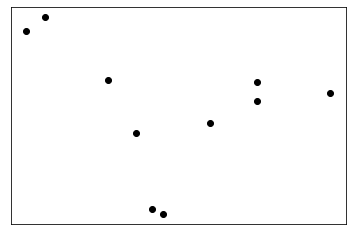

In [6]:
np.random.seed(9102)
X = np.random.uniform(low=0, high=10, size=10)
Y = np.sin(X) + np.random.normal(scale=0.5, size=10)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

plt.plot(X, Y, 'ko')
plt.xticks([])
plt.yticks([]);

In [7]:
k = gpflow.kernels.SquaredExponential()
# k = gpflow.kernels.Matern12()
# k = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

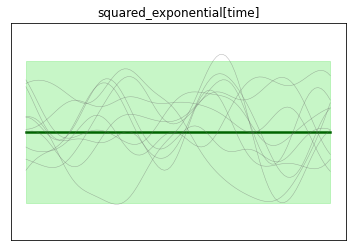

In [8]:
xx = np.linspace(0, 10, 100).reshape(100, 1)  # test points must be of shape (N, D)

# sample from prior
np.random.seed(9102)
mean = m.mean_function(xx).numpy().flatten()
var = m.kernel.K_diag(xx)
samples = np.random.multivariate_normal(
    mean=m.mean_function(xx).numpy().flatten(), 
    cov=m.kernel(xx),
    size=10)

# ## predict mean and variance of latent GP at test points
# mean, var = m.predict_f(xx)

# ## generate 10 samples from posterior
# tf.random.set_seed(9102)  # for reproducibility
# samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
# plt.figure(figsize=(12, 6))
# plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "darkgreen", lw=2.5)
plt.fill_between(
    xx[:, 0],
     - 1.96 * np.sqrt(var),
     + 1.96 * np.sqrt(var),
    color="lightgreen",
    alpha=0.5,
)

plt.plot(xx, samples.T, "dimgray", linewidth=0.5, alpha=0.5)
plt.ylim(-3, 3)
plt.title('squared_exponential[time]')
plt.xticks([])
plt.yticks([]);

In [9]:
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.749872  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.740194  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0379764 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

In [10]:
# SE = -9.91
# M12 = -10.68
# Per = -12.242
m.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-9.914289155637>

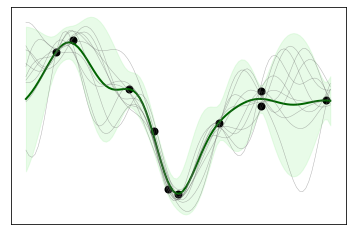

In [11]:
# Prediction
## generate test points for prediction
xx = np.linspace(0, 10, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
#plt.figure(figsize=(12, 6))
plt.plot(X, Y, "ko", mew=2)
plt.plot(xx, mean, "darkgreen", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="lightgreen",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "dimgray", linewidth=0.5, alpha=0.5)
plt.xticks([])
plt.yticks([]);

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


([], <a list of 0 Text major ticklabel objects>)

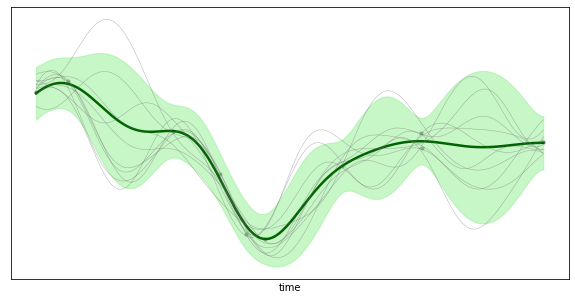

In [13]:
gp_predict_fun(m, 0, 0, col_names=['time'])
plt.xticks([])
plt.yticks([])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Text(0.5, 0, '')

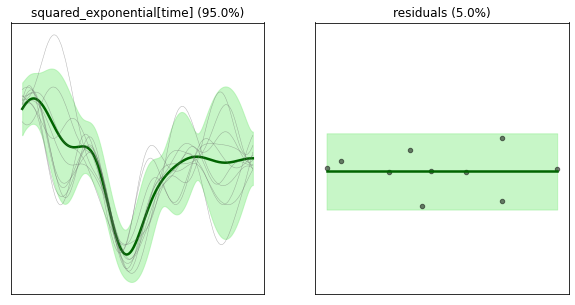

In [14]:
fig, ax = pred_kernel_parts(m, 'squared_exponential[0]', 0, 0, col_names=['time'])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_xlabel('')
ax[1].set_xlabel('')

In [15]:
hmc_out = hmc_sampling(m, samples=500)

In [16]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.749872
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.740194
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0379764


In [17]:
m.trainable_parameters

(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7401937019825038>,
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7498722077802612>,
 <Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.03797644835355126>)

In [18]:
post_samps = {'variance': hmc_out['samples'][0].numpy(),
              'lengthscales': hmc_out['samples'][1].numpy(),
              'like_variance': hmc_out['samples'][2].numpy()}

In [19]:
m.trainable_parameters[0].numpy()

array(0.7401937)

Text(0.5, 1.0, 'Likelihood variance')

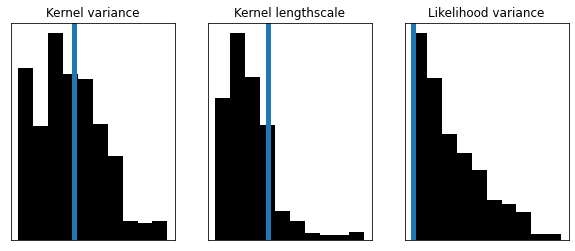

In [20]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10,4))
axs[0].hist(post_samps['variance'], color='black');
axs[0].axvline(m.trainable_parameters[0].numpy(), lw=5)
axs[1].hist(post_samps['lengthscales'], color='black');
axs[1].axvline(m.trainable_parameters[1].numpy(), lw=5)
axs[2].hist(post_samps['like_variance'], color='black');
axs[2].axvline(m.trainable_parameters[2].numpy(), lw=5)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
axs[2].set_xticklabels([])
axs[2].set_yticklabels([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[0].set_title('Kernel variance')
axs[1].set_title('Kernel lengthscale')
axs[2].set_title('Likelihood variance')

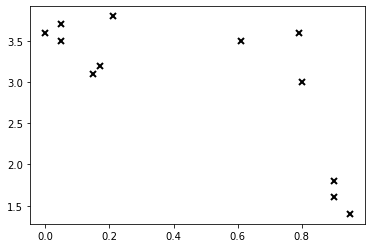

In [ ]:
# data = np.genfromtxt("data/regression_1D.csv", delimiter=",")
# X = data[:, 0].reshape(-1, 1)
# Y = data[:, 1].reshape(-1, 1)

X = np.array([0, 0.05, 0.05, 0.15, 0.17, 0.21, 0.61, 0.79, 0.8, 0.9, 0.9, 0.95]).reshape(-1,1)
Y = np.array([3.6, 3.7, 3.5, 3.1, 3.2, 3.8, 3.5, 3.6, 3.0, 1.8, 1.6, 1.4]).reshape(-1,1)



plt.plot(X, Y, "kx", mew=2);

In [ ]:
k = gpflow.kernels.Matern52()
print_summary(k)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern52.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern52.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


In [ ]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [ ]:
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 7.76607   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.492535  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0969323 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

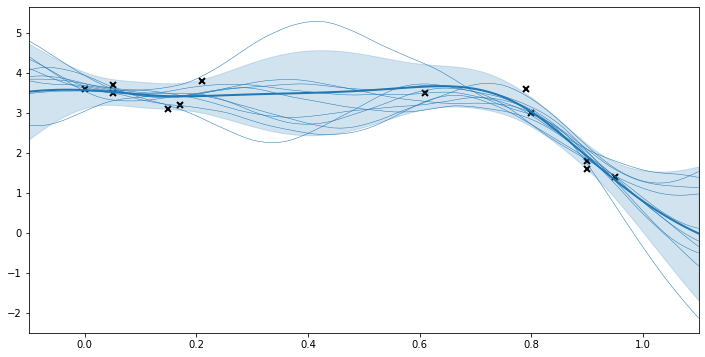

In [ ]:
# Prediction
## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
_ = plt.xlim(-0.1, 1.1)

